In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import importlib
import transformer_type
from transformer_type.dataset import get_data
import torch
import pandas as pd

if torch.cuda.is_available(): device = torch.device ("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')

from tqdm import tqdm

In [2]:
# params = [120, 1, 64, 300, 32, 512, 2, 1e-5, 0.1]
# 120-1_64_32-2_1e-05_100
# params = {'input_window' : [120],
#          'pred_step' : [60],
#          'batch_size' : [64],
#          'epochs' : [100],
#          'feature_size' : [64],
#          'd_ff' : [32],
#          'num_layers' : [2],
#          'lr' : [1e-5],
#          'device' : [device],
#          'dropout' : [0.1],
#          'is_save' : [True]}

# best loss
# params = {'input_window' : [120],
#           'pred_step' : [60],
#          'batch_size' : [64],
#          'epochs' : [100],
#          'feature_size' : [128],
#          'd_ff' : [512],
#          'num_layers' : [2],
#          'lr' : [1e-5],
#          'device' : [device],
#          'dropout' : [0.1],
#          'is_save' : [True]}

params = {'input_window' : [180],
          'pred_step' : [60],
         'batch_size' : [64],
         'epochs' : [30],
         'feature_size' : [16, 64, 128],
         'd_ff' : [16, 32, 256], # 작으면 초반 솟아오름
         'num_layers' : [4, 2, 1],
         'lr' : [1e-6],
         'device' : [device],
         'dropout' : [0.1],
         'is_save' : [True],
         'diff' : [False],
         'mean_std' : [False],}



# params = {'input_window' : [60],
#           'pred_step' : [60],
#          'batch_size' : [64],
#          'epochs' : [10],
#          'feature_size' : [16],
#          'd_ff' : [16],
#          'num_layers' : [1],
#          'lr' : [1e-5],
#          'device' : [device],
#          'is_save' : [True],
#          'diff' : [True],
#          'mean_std' : [True]}

In [3]:
DATA_PATH = "../../data/kaggle_data/"

In [4]:
params['mean_std'][0]

False

In [5]:

# make dataset

def data_extract(df_dict, df, name, cols):
       for col in cols:
              df_dict[f"{name}_{col}"] = df.loc[df[col] != 0, col]
       return df_dict

train_data_list = []
val_data_list = []


# rom_df = pd.read_csv(DATA_PATH + "romania_elec_daily.csv")
# rom_cols = ['Consumption']
pmj_df = pd.read_csv(DATA_PATH + "pjm_elec_daily.csv")
pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW'] # 'PJM_Load', 'EKPC'
# pmj_cols = ['DUQ']

# ind_df = pd.read_csv(DATA_PATH + "india_elec_daily.csv")
# ind_cols = ['Punjab', 'Haryana', 'Rajasthan', 'Delhi', 'UP',
#        'Uttarakhand', 'HP', 'J&K', 'Chandigarh', 'Chhattisgarh', 'Gujarat',
#        'MP', 'Maharashtra', 'Goa', 'DNH', 'Andhra Pradesh', 'Telangana',
#        'Karnataka', 'Kerala', 'Tamil Nadu', 'Pondy', 'Bihar', 'Jharkhand',
#        'Odisha', 'West Bengal', 'Sikkim', 'Arunachal Pradesh', 'Assam',
#        'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
# mal_df = pd.read_csv(DATA_PATH + "malaysia_elec_daily.csv")
# mal_cols = ['load']
# tet_df = pd.read_csv(DATA_PATH + "tetouan_elec_daily.csv")
# tet_cols = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']
# steel_df = pd.read_csv(DATA_PATH + "steel_industry_elec_daily.csv")
# steel_cols = ['Usage_kWh']

df_dict = {}

# df_dict = data_extract(df_dict, rom_df, 'ROM', rom_cols)
df_dict = data_extract(df_dict, pmj_df, 'PMJ', pmj_cols)

# df_dict = data_extract(df_dict, mal_df, 'MAL', mal_cols)
# df_dict = data_extract(df_dict, ind_df, 'IND', ind_cols)
# df_dict = data_extract(df_dict, tet_df, 'TET', tet_cols)
# df_dict = data_extract(df_dict, steel_df, 'STEEL', steel_cols)

for df_name in df_dict:
    df = df_dict[df_name]
    train_data, val_data, scaler = get_data(df,
                                            params['input_window'][0],
                                            1,
                                            scaler_name='mm',
                                            diff=params['diff'][0],
                                            mean_std=params['mean_std'][0])
    train_data = train_data.to(device)
    val_data = val_data.to(device)
    print(df_name, len(train_data), len(val_data))
    train_data_list.append((train_data, df_name, scaler))
    val_data_list.append((val_data, df_name, scaler))
    break


PMJ_AEP 3863 830


In [6]:
for i, iw in enumerate(params['input_window']):
    diff, mean_std = params['diff'][i], params['mean_std'][i]
    input_len = iw
    if diff:
        input_len += iw + 1
    if mean_std:
        input_len += 4
    params['input_window'][i] = input_len


In [7]:
cnt = 0
total = 1
best_models, models = None, None
for param in params:
    total *= len(params[param])


def select_param(params, param_names, selected_params=[], param_idx=0):
    if param_idx == len(params):
        global best_models, models
        importlib.reload(transformer_type)
        from transformer_type.transformer_multistep import train_start
        torch.cuda.empty_cache()
        global cnt
        cnt += 1
        print(f"Start training ({cnt} / {total})")
        for param_name, params in zip(param_names, selected_params):
            print(f"{param_name} : {params}", end= ' | ')
        print()
        selected_params = [train_data_list, val_data_list] + selected_params
        best_models, models = train_start(*selected_params)
        return
    
    param_name = param_names[param_idx]
    param_list = params[param_name]
    for parameter in param_list:
        select_param(params, param_names, selected_params + [parameter], param_idx + 1)


In [8]:
# type_120-120_32_64-512-2_0.0005_200_0.1
# type_120-120_32_128-256-2_0.0005_200_0.1
# type_120-120_32_128-512-2_0.0005_200_0.1
# type_120-120_32_128-1024-2_0.0005_200_0.1

In [9]:
train_data_list[0][0][0]

tensor([[0.5880, 0.5570, 0.5222, 0.6159, 0.6218, 0.6211, 0.6222, 0.6178, 0.5541,
         0.5237, 0.6155, 0.6297, 0.6224, 0.6238, 0.6261, 0.5841, 0.5614, 0.6661,
         0.6383, 0.6254, 0.6190, 0.6160, 0.5685, 0.5318, 0.6234, 0.6314, 0.6222,
         0.6167, 0.6137, 0.5536, 0.5035, 0.6165, 0.6283, 0.6312, 0.6478, 0.6440,
         0.5976, 0.5545, 0.6534, 0.7040, 0.6939, 0.6769, 0.6723, 0.6228, 0.6205,
         0.6967, 0.6830, 0.6641, 0.6532, 0.6345, 0.5727, 0.5561, 0.6411, 0.6414,
         0.6421, 0.5694, 0.6216, 0.6073, 0.6099, 0.7160, 0.7079, 0.6994, 0.7349,
         0.7183, 0.6745, 0.6258, 0.6926, 0.6667, 0.6744, 0.7133, 0.6779, 0.6668,
         0.6612, 0.7666, 0.8159, 0.8148, 0.8021, 0.7513, 0.7202, 0.7454, 0.9108,
         0.8114, 0.7548, 0.7092, 0.7131, 0.7088, 0.6953, 0.7977, 0.7871, 0.7046,
         0.6579, 0.6069, 0.5568, 0.5771, 0.6544, 0.6732, 0.7022, 0.6748, 0.7026,
         0.6532, 0.6279, 0.7038, 0.7112, 0.6621, 0.6481, 0.7220, 0.7173, 0.7237,
         0.8732, 0.9082, 0.8

In [10]:
torch.autograd.set_detect_anomaly(True)
select_param(params, list(params.keys()))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Start training (1 / 27)
input_window : 180 | pred_step : 60 | batch_size : 64 | epochs : 30 | feature_size : 16 | d_ff : 16 | num_layers : 4 | lr : 1e-06 | device : cuda | dropout : 0.1 | is_save : True | diff : False | mean_std : False | 


wandb: Currently logged in as: qja1998. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
 70%|███████   | 21/30 [06:35<02:49, 18.83s/it]


KeyboardInterrupt: 

In [ ]:
from transformer_type.model import TransAm

pred_seq = 60

model_param = (params['input_window'][0], params['feature_size'][0], params['num_layers'][0], params['d_ff'][0], params['dropout'][0])
MODEL_PATH = f"transformer_results/type_{model_param[0]}-60_64_{model_param[1]}-{model_param[3]}-{model_param[2]}_1e-05_100_{model_param[4]}"
models = {'PMJ_' + t : TransAm(*model_param[1:]) for t in pmj_cols}
for t in pmj_cols:
    models['PMJ_' + t].load_state_dict(torch.load(MODEL_PATH + f"/models/PMJ_{t}.pt"))
    models['PMJ_' + t].to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'transformer_results/type_120-60_64_128-32-4_1e-05_100_0.1/models/PMJ_AEP.pt'

In [ ]:
def inverse_scaling(value):
    return float(scaler.inverse_transform(value.cpu().detach().reshape(1, -1)))

In [ ]:
cur_values = {}
predictions = {}
true_values = {}
input_window, output_window = 120, 1

predictions_period = {}
true_values_period = {}
cur_values_period = {}

for val_data, t, scaler in val_data_list[:]:
    model = models[t]
    model.eval()
    cur_values[t] = []
    predictions[t] = []
    true_values[t] = []

    predictions_period[t] = []
    true_values_period[t] = []
    cur_values_period[t] = []

    for i in tqdm(range(len(val_data) - pred_seq)):
        data = val_data[i][0][:-1].reshape(-1, 1, 1)
        data.to(device)
        cur_values[t].append(float(scaler.inverse_transform(val_data[i][1][-1].cpu().detach().reshape(1, -1))))
        cur_values_period[t].append([float(scaler.inverse_transform(val_data[i][1][-1].cpu().detach().reshape(1, -1)))] * pred_seq)
        for _ in range(pred_seq):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = model(data[-input_window:])
            data = torch.cat((data[:-1], output[-1:], torch.Tensor([[[.0]]]).to(device)))
        predictions[t].append(float(scaler.inverse_transform(output[-1:].cpu().detach().reshape(1, -1))))
        true_values[t].append(float(scaler.inverse_transform(val_data[i + pred_seq][1][-1].cpu().detach().reshape(1, -1))))

        predictions_period[t].append([inverse_scaling(d) for d in list(data[-pred_seq-1:-1])])
        true_values_period[t].append([inverse_scaling(d) for d in list(val_data[i + pred_seq][1][-pred_seq-1:-1])])

100%|██████████| 1073/1073 [04:24<00:00,  4.06it/s]


In [ ]:
for name in predictions_period:
    df = pd.DataFrame(predictions_period[name]).T
    df.to_csv(f"{MODEL_PATH}/{name}_{pred_seq}.csv")

tensor(0.1798)
tensor(0.1114)
tensor(0.2392)
tensor(1.2150)
tensor(0.0781)
tensor(0.3624)
tensor(0.0936)
tensor(0.1827)
tensor(0.1481)
tensor(0.0668)


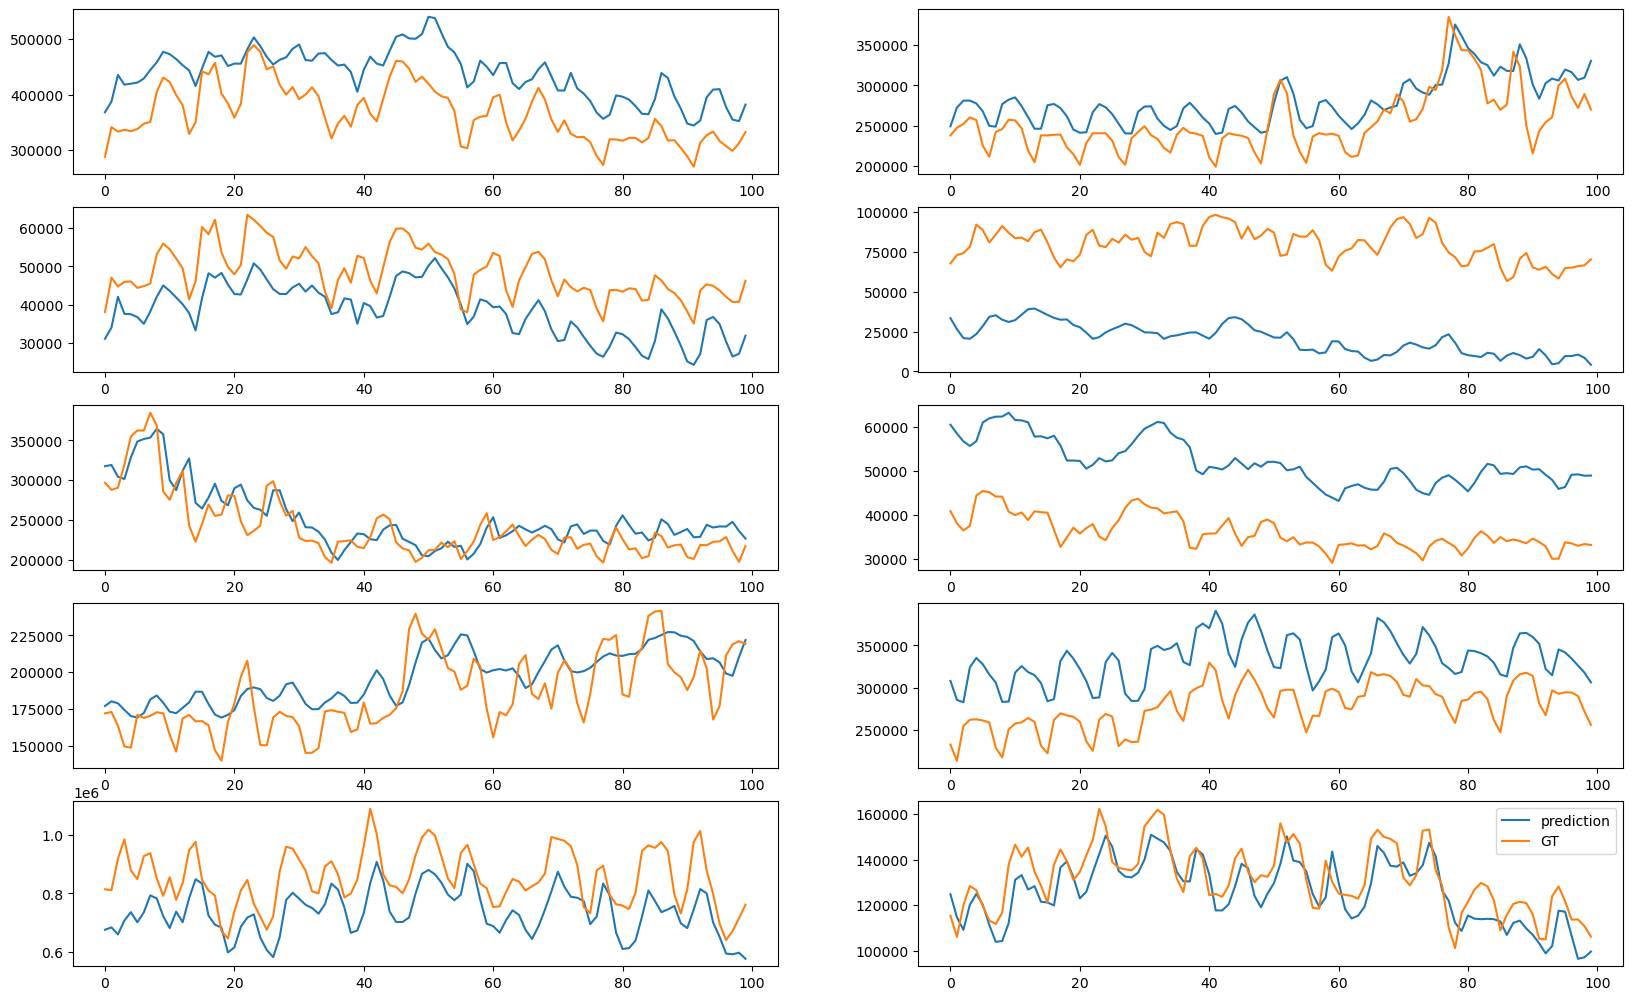

In [ ]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE, MeanAbsolutePercentageError as MAPE, R2Score as R2
import matplotlib.pyplot as plt

# tensor(0.0757)
# tensor(0.1433)
# tensor(0.2411)
# tensor(0.1079)
# tensor(0.2570)
# tensor(0.1562)
# tensor(0.1002)
# tensor(0.2347)
# tensor(0.1141)
# tensor(0.2481)

smape = SMAPE()
idx = 0
sub_num = 1
plt.figure(figsize=(20, 15 * len(predictions_period) // len(val_data_list)))
for t in predictions_period:
    pred, true_val = [], []
    for p, gt in zip(predictions_period[t][idx : idx + 100], true_values_period[t][idx : idx + 100]):
        pred += p[:1]
        true_val += gt[:1]
    plt.subplot(len(predictions_period) // 2 + 1, 2, sub_num)
    plt.rc('font', size=10)
    plt.plot(pred, label='prediction')
    plt.plot(true_val, label="GT")
    print(smape(torch.tensor(pred), torch.tensor(true_val)))

    sub_num += 1

plt.legend()
plt.show()